In [0]:
!pip install librosa -U
import numpy as np
from scipy.io.wavfile import read
from scipy.signal import firwin, find_peaks
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from glob import glob
import librosa

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive
!mkdir input
!mv *ventilatr* input; cd input

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive
mkdir: cannot create directory ‘input’: File exists
mv: cannot stat '*ventilatr*': No such file or directory


In [0]:
# put your .wav file in input directory
data_dir = './input'
audio_files = glob(data_dir + '/*.wav')

In [0]:
audio_files

['./input/s04400_190717_002_ventilatrright_002_EM1_OB_01_C12_SB1_L0_XX_0002_YY_YYYY_ZZZZZZ_1.wav',
 './input/s99999_200116_002_ventilatrright_002_EM1_OB_01_CXX_SB1_L0_XX_0002_YY_YYYY_ZZZZZZ_5.wav']

# Bearing Failure Frequency Calculation

In [0]:
# @Igor: this is the formula to calculate the different bearing failure frequencies...it requires user input

# This needs to be provided by the user
rpm = 100 
rps = rpm/60
n = 11
bd = 0.255 
pd = 1.318
beta = 0
#--------------
tol = .03 # match tolerance
##################################
BPFO = n/2*(rps*(1-bd/pd*np.cos(beta)))
BPFI = n/2*(rps*(1+bd/pd*np.cos(beta)))
BSF = (pd*rps)/(bd*2)*((1-((bd/pd)**2)*(np.cos(beta))**2))
FTF = rps/2*(1-bd/pd*np.cos(beta))
# fault check parameters
f_check = [BPFO, BPFI, BSF, FTF]   # freqs to check
print('Outer Ring rate - BPFO', BPFO)
print('Inner Ring rate - BPFI', BPFI)
print('Ball spin rate - BSF', BSF)
print('Fundamental Train Frequency - FTF', FTF)

Outer Ring rate - BPFO 7.393146181082448
Inner Ring rate - BPFI 10.940187152250884
Ball spin rate - BSF 4.145960407430549
Fundamental Train Frequency - FTF 0.6721041982802226


In [0]:
# failure check function --------------------------------
def find_faults(x, fs, f_check, tol, label):
  dist = 100  # min distance between peaks in samples
  nMax = 10   # peaks amount
  thrsh = 5   # spectrum magnitude threshold
  names = ['outer ring', 'inner ring', 'ball      ', 'cage      ']
  i = 0  
  fSpec, xSpec = envspectrum(x, fs)  #get envelope spectrum
  # find n max peaks
  inds, _ = find_peaks(xSpec, distance=dist)
  peaks = xSpec[inds]
  n_maxs = peaks.argsort()[-nMax:][::-1]   #get nMax peaks
  n_inds = inds[n_maxs]
  # find mode distance
  inds_dist, _ = find_peaks(xSpec, distance=dist, height=thrsh)
  f_dist = fSpec[inds_dist]
  f_diff = np.diff(f_dist) 
  hist, edg = np.histogram(f_diff, bins=100, range=(np.median(f_diff)/1.1, np.median(f_diff)*1.1) )
  mode_freq = (edg[np.argmax(hist)]+edg[np.argmax(hist)+1])/2
  # find matched peaks with probs
  f_peaks = fSpec[n_inds]  # freq of n max peaks
  # plot n max peaks -----------
  lim_f = np.max(n_inds)*2   # x limits for plot 
  plt.figure(figsize=(20,5))
  plt.plot(fSpec[:lim_f],xSpec[:lim_f])  # plot only part for convenience
  plt.plot(fSpec[n_inds],xSpec[n_inds], '*')
  plt.title(label[:40]  + "\n max %d" %nMax +" peaks, mode freq = %.2f" % mode_freq + " Hz")
  plt.xlabel('frequency, Hz')
  plt.ylabel('spectrum magnitude')
  # find peak matches
  max_probs = []  # max probabilities for each check freq
  print("------\n"+label[:30])   # print file name
  for ch in f_check:   # freqs to check
    prob = []
    for pk in f_peaks:  # n max peaks comparing
      err = np.min([np.abs(1-pk/ch), .5])  # relative error of match, should be less 50%
      const = -np.log(.3)/tol   # match probability curve const
      prob.append(1/np.exp(err*const))  # probability
    ind_max = np.argmax(prob)   # max probability among n peaks
    # check peak match    
    if np.max(prob) > .3:   # if probability within tolerance
      print("   %d" % (np.max(prob)*100) + "%  " + names[i] + "  failure detected", end='')
      errors_2 = np.abs(f_peaks-2*f_peaks[ind_max])/2/f_peaks[ind_max]  #find 2nd peak among n max  
      if np.min(errors_2) < tol:   #if 2nd peak within tol
        ind_2 = np.argmin(errors_2)   # ind of 2nd peak
        p1 = xSpec[n_inds[ind_max]] #1st magn
        p2 = xSpec[n_inds[ind_2]] #2nd magn
        rat = p2/p1  # peak ratio
        ch_out = [np.max(prob), ind_max, ind_2] #1st peak prob, 1st & 2nd peak inds             
        if np.abs(1-rat) < .1:
          print("   No Imbalance or Misalignment detected")
          col='green'
        elif rat > 1:
          print("   Misalignment detected ")
          col='red'
        else:
          print("   Imbalance detected")
          col='magenta'
        # show match on plot
        plt.annotate("", 
              xy=(ch*2, xSpec[n_inds[ind_2]]), 
              xytext=(ch, xSpec[n_inds[ind_max]]),
              arrowprops = dict(facecolor=col, arrowstyle="wedge, tail_width=0.4", connectionstyle="arc3, rad=-.3"))     
        plt.text(ch*.8, xSpec[n_inds[ind_max]]*1.02, "%.1fHz"%ch, color=col)  #add freq to plot
        #add legend
        patch1 = mpatches.Patch(color='green', label='No Imbalance or Misalignment')
        patch2 = mpatches.Patch(color='red', label='Misalignment')
        patch3 = mpatches.Patch(color='magenta', label='Imbalance')
        plt.legend(handles=[patch1,patch2,patch3])   
      else:    # no 2nd peak
        ch_out = [np.max(prob), ind_max]
        print("   No 2nd peak found")
    else:  # no 1st peak
      ch_out = []
      print("    0%  " + names[i] + "  failure detected")
    max_probs.append(ch_out)  # append found peaks for ch
    i=i+1

  return max_probs, fSpec, xSpec, n_inds, mode_freq

# spectrum envelope--------------------------------
def envspectrum(x, fs):
  fo = 50
  ba = [1/2, 3/4]
  b = firwin(fo, ba, pass_zero=False)
  x = x - np.mean(x)
  xBandPass = np.convolve(x, b, 'same')
  xAn = hilbert(xBandPass)

  xEnv = np.abs(xAn)
  xEnv = xEnv - np.mean(xEnv)
  leng = xEnv.shape[0]
  fSpec = np.arange(leng) / leng * fs
  xSpec = 1/leng * np.abs(np.fft.fft(xEnv))
  # get only part of spectrum
  if xSpec.shape[0] % 2 != 0:
      # Odd length two-sided spectrum
      fSpec = fSpec[:(fSpec.shape[0]+1)//2]
      xSpec = xSpec[:(xSpec.shape[0]+1)//2]
      xSpec[1:] = 2*xSpec[1:]
  else:
      # Even length two-sided spectrum
      fSpec = fSpec[:fSpec.shape[0]//2+1]
      xSpec = xSpec[:xSpec.shape[0]//2+1]
      xSpec[1:-1] = 2*xSpec[1:-1]
  return fSpec, xSpec

# hilbert transform function --------------------------
def hilbert(x):
  # get real part
  x = np.real(x)
  x = np.fft.fft(x) # fft
  n = x.shape[0] # length
  # nx1 for nonempty. 0x0 for empty.
  if np.size(x) == 0:
    emp = 0
  else:
    emp = 1
  # create support vector
  h = np.zeros([n, emp])
  if n > 0 and 2*np.fix(n/2) == n:
    # even and nonempty
    h[0] = 1
    h[int(n/2)] = 1
    h[1:int(n/2)] = 2
  elif n>0:
    # odd and nonempty
    h[0] = 1
    h[1:int((n+1)/2)] = 2  
  # transpose for multiplication
  h = np.transpose(h)
  # separate real and imag part to multiply by h element-wise
  re = np.multiply(np.real(x), h)
  im = np.multiply(np.imag(x), h)
  # combine re and im parts back 
  com = re + 1j * im
  xAn = np.fft.ifft(com)  # get ifft
  xAn = xAn.transpose() # transpose for convenience
  xAn = np.squeeze(xAn)
  return xAn

------
./input/s04400_190717_002_vent
    0%  outer ring  failure detected
   48%  inner ring  failure detected   No Imbalance or Misalignment detected
   63%  ball        failure detected   Imbalance detected
    0%  cage        failure detected
------
./input/s99999_200116_002_vent
   92%  outer ring  failure detected   No Imbalance or Misalignment detected
    0%  inner ring  failure detected
   84%  ball        failure detected   Imbalance detected
    0%  cage        failure detected


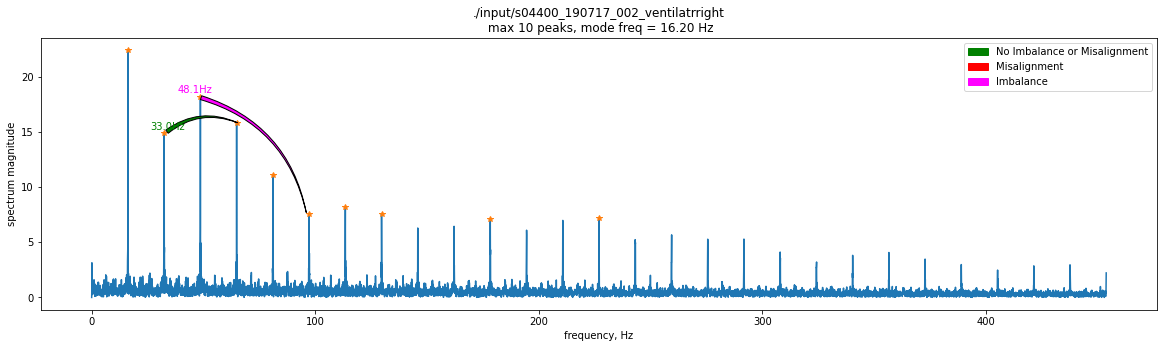

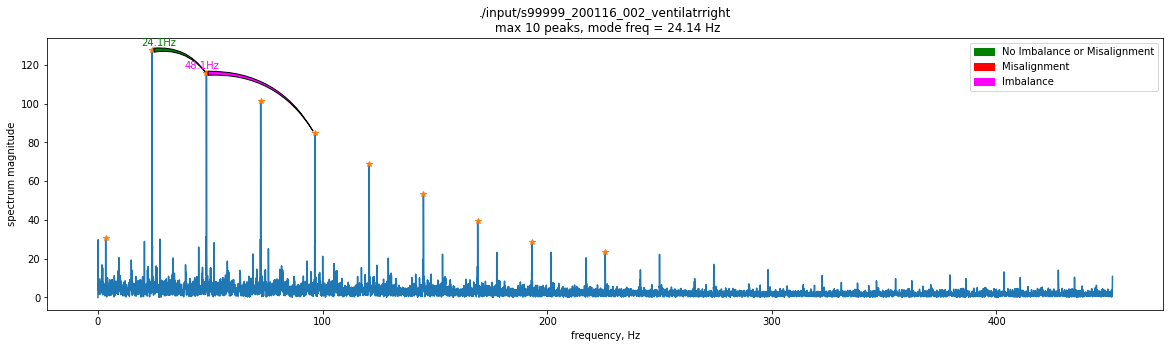

In [0]:
f_check = [24.10, 33, 48.1, 58.6]  # test with these freqs
for file_in in audio_files:
    # read file
    x, fs = librosa.core.load(file_in, sr=None, mono=True)
    # find failures
    probs, fSpec, xSpec, n_inds, mode_freq = find_faults(x, fs, f_check, tol, file_in)

# Misalignment Calculation / Imbalance Calculation

In [0]:
print (mode_freq) #prints interval between peaks 

24.190615909090905


In [0]:
print (fSpec[max_inds]) # prints top 10 frequencies

[ 24.2   72.55  96.75  48.35 120.95   0.1  145.1  169.3  193.5   57.6 ]
